**Project:** Short-term forecasting of Dmart (DMART.NS) using LSTM, generating trade signals, backtesting performance, and visualizing results.

This notebook includes:
- Data download (yfinance)
- Feature engineering (EMA, RSI, volatility)
- Sequence creation (lookback)
- LSTM model (Keras)
- Training, prediction, and signal conversion
- Backtest and performance metrics
- Save model & artifacts

Import Code

In [34]:
# Imports
import os, math, json, random, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


Configurable Parameters

In [48]:
# Config
DATA_SYMBOL = 'DMART.NS'   # Yahoo Finance symbol for DMART
START = '2010-01-01'
END = None  # use latest
LOOKBACK = 60
BATCH_SIZE = 64
EPOCHS = 30
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Data Download

In [36]:
# Download data (yfinance). If running in offline environment, replace with local CSV.
import yfinance as yf
df = yf.download(DATA_SYMBOL, start=START, end=END)
df = df[['Open','High','Low','Close','Volume']].dropna()
df.tail()

/tmp/ipython-input-3537634494.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(DATA_SYMBOL, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,DMART.NS,DMART.NS,DMART.NS,DMART.NS,DMART.NS
Date,,,,,
2025-12-08,3950.000000,3955.199951,3826.600098,3867.600098,268207
2025-12-09,3867.600098,3920.000000,3841.699951,3910.000000,255693
2025-12-10,3891.000000,3923.699951,3805.000000,3816.300049,576341
2025-12-11,3820.000000,3848.800049,3770.000000,3830.800049,396885
2025-12-12,3830.800049,3868.600098,3812.500000,3818.199951,63039


Feature Engineering

In [37]:
# Feature engineering: log returns, EMA, RSI, volatility
def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=(period-1), adjust=False).mean()
    ma_down = down.ewm(com=(period-1), adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

data = df.copy()
data['log_ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['RSI_14'] = rsi(data['Close'], 14)
data['vol_10'] = data['log_ret'].rolling(window=10).std() * np.sqrt(252)
data = data.dropna()
data.tail()


Price,Open,High,Low,Close,Volume,log_ret,EMA_20,EMA_50,RSI_14,vol_10
Ticker,DMART.NS,DMART.NS,DMART.NS,DMART.NS,DMART.NS,,,,,
Date,,,,,,,,,,
2025-12-08,3950.000000,3955.199951,3826.600098,3867.600098,268207,-0.021613,4001.876206,4134.443177,29.819923,0.148834
2025-12-09,3867.600098,3920.000000,3841.699951,3910.000000,255693,0.010903,3993.126091,4125.641484,36.219116,0.164252
2025-12-10,3891.000000,3923.699951,3805.000000,3816.300049,576341,-0.024256,3976.285516,4113.510448,29.760851,0.188231
2025-12-11,3820.000000,3848.800049,3770.000000,3830.800049,396885,0.003792,3962.429757,4102.423765,31.787848,0.193445
2025-12-12,3830.800049,3868.600098,3812.500000,3818.199951,63039,-0.003295,3948.693585,4091.277733,30.951951,0.193299


Prepare Sequences & Targets

In [38]:
# Prepare sequences (LOOKBACK) and target = next-day pct change (unscaled)
features = ['Close','EMA_20','EMA_50','RSI_14','vol_10']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled, index=data.index, columns=features)

def create_sequences(arr, lookback=LOOKBACK):
    X, y = [], []
    for i in range(len(arr)-lookback-1):
        X.append(arr[i:i+lookback])
        # target: next-day pct change using actual close values (we will compute separately aligned to index)
        y.append(arr[i+lookback][0] - arr[i+lookback-1][0])  # small difference in scaled space
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values, LOOKBACK)
print('X shape', X.shape, 'y shape', y.shape)


X shape (2089, 60, 5) y shape (2089,)


Train/Val/Test Split

In [39]:
# Train-validation-test split (70/15/15)
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:len(y)]
print('Train', X_train.shape, 'Val', X_val.shape, 'Test', X_test.shape)


Train (1462, 60, 5) Val (313, 60, 5) Test (314, 60, 5)


Build LSTM Model

In [40]:
# Build LSTM model
def build_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)  # predict scaled next-day delta
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
    return model

model = build_lstm((LOOKBACK, len(features)))
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

Train Mode

In [41]:
# Train model with early stopping and checkpointing
checkpoint_path = os.path.join(MODEL_DIR, 'lstm_ng.h5')
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 8.7422e-04 - mae: 0.0228

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 8.5898e-04 - mae: 0.0225 - val_loss: 2.8594e-04 - val_mae: 0.0130
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.1838e-04 - mae: 0.0111

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 2.1762e-04 - mae: 0.0110 - val_loss: 1.9940e-04 - val_mae: 0.0102
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.6246e-04 - mae: 0.0089

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 1.6266e-04 - mae: 0.0089 - val_loss: 1.9238e-04 - val_mae: 0.0100
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.5593e-04 - mae: 0.0086 - val_loss: 2.0773e-04 - val_mae: 0.0105
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 1.5808e-04 - mae: 0.0087 - val_loss: 2.0541e-04 - val_mae: 0.0104
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 1.5408e-04 - mae: 0.0086 - val_loss: 1.9297e-04 - val_mae: 0.0100
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.3398e-04 - mae: 0.0082 - val_loss: 2.1547e-04 - val_mae: 0.0107
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1.5835e-04 - mae: 0.0084 - val_loss: 1.9660e-04 - val_mae: 0.0101
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.5542e-04 - mae: 0.0086 - val_loss: 1.9623e-04 - val_mae: 0.0100


Plot Training Curves

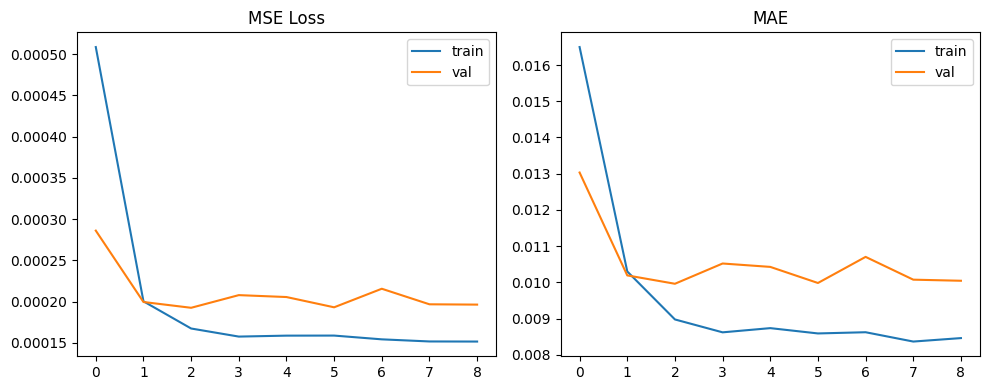

In [42]:
# Plot loss and MAE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('MSE Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.title('MAE'); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'))
plt.show()


Predict on Test & Align Real Returns

In [43]:
# Predict on test set
preds = model.predict(X_test).squeeze()

# Create aligned test index and real returns for evaluation/backtesting:
# The test period in 'data' corresponds to the final portion after LOOKBACK + val_end
start_idx = LOOKBACK + val_end
test_index = data.index[start_idx+1 : start_idx+1+len(preds)]  # +1 for next-day alignment

# Real percent returns for the test aligned window
# Ensure real_close is a 1D array for np.diff
real_close = data['Close'].iloc[start_idx : start_idx + 1 + len(preds)].values.flatten()  # Added .flatten()
real_returns = np.diff(real_close) / real_close[:-1]  # length = len(preds)

print('Predictions shape:', preds.shape, 'Real returns shape:', real_returns.shape)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Predictions shape: (314,) Real returns shape: (314,)


Directional Accuracy

In [44]:
# Convert predictions (scaled deltas) to directional signals and compute approximate directional accuracy
pred_dir = (preds > 0).astype(int)
true_dir = (real_returns > 0).astype(int)
directional_accuracy = np.mean(pred_dir == true_dir)
print('Directional accuracy on test (approx): {:.2%}'.format(directional_accuracy))


Directional accuracy on test (approx): 46.50%


Generate Signals & Backtest

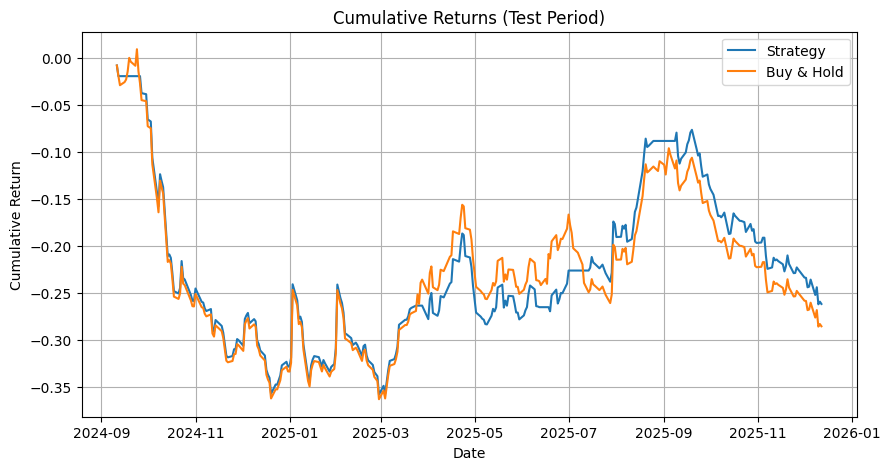

In [45]:
# Trading rule: go long if predicted positive, else flat. No leverage, no shorting.
signals = pred_dir   #1 = long, 0 = flat
strategy_returns = signals * real_returns  # elementwise
# cumulative returns (strategy and buy-and-hold)
cum_strategy = np.cumprod(1 + strategy_returns) - 1
cum_bh = np.cumprod(1 + real_returns) - 1

plt.figure(figsize=(10,5))
plt.plot(test_index, cum_strategy, label='Strategy')
plt.plot(test_index, cum_bh, label='Buy & Hold')
plt.legend(); plt.title('Cumulative Returns (Test Period)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'cum_returns.png')); plt.show()


Performance Metrics

In [46]:
# Performance metrics: Sharpe (approx), CAGR, Max Drawdown, Hit ratio
def sharpe(returns, periods_per_year=252):
    mean = np.mean(returns) * periods_per_year
    vol = np.std(returns) * np.sqrt(periods_per_year)
    return mean / (vol + 1e-9)

def max_drawdown(cumret):
    peak = np.maximum.accumulate(cumret + 1)
    drawdown = (cumret + 1) / peak - 1
    return drawdown.min()

sr = sharpe(strategy_returns)
sr_bh = sharpe(real_returns)
mdd = max_drawdown(cum_strategy)
hit = np.mean(strategy_returns > 0)

print(f"Strategy Sharpe (approx): {sr:.3f}")
print(f"Buy&Hold Sharpe (approx): {sr_bh:.3f}")
print(f"Strategy Max Drawdown: {mdd:.3%}")
print(f"Hit Ratio: {hit:.2%}")


Strategy Sharpe (approx): -0.749
Buy&Hold Sharpe (approx): -0.801
Strategy Max Drawdown: -35.263%
Hit Ratio: 39.17%


Confusion Matrix for Direction

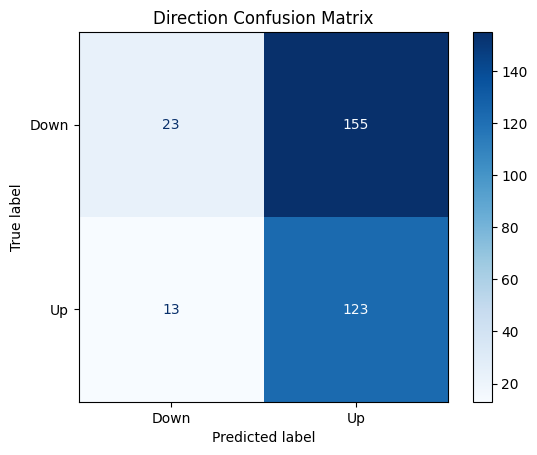

In [47]:
# Confusion matrix for direction prediction
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_dir, pred_dir)
disp = ConfusionMatrixDisplay(cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Direction Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()
